# Case | Song recommendation

This notebook creates a pipeline to get song recommendation based on songs in the Billboard Hot 100 list. A user can run a search for a song title and - if it is present in the Hot 100 list - is recommended a similar song based on a model of song clustering, or a song with that title is added to the cluster model.

### 1. Billboard Hot 100 data

Web scraping The Billboars Hot 100 list and creating a user search that enables the user to check if a song is in the Hot 100.

### 2. Spotify data

Using Spotify APIs to retrieve song info and audio features for tracks in the Hot 100 list. The info is gathered for the song selected by the user as well as for all songs in the list to train the model in the next step.

### 3. Clustering 

Building a KMeans clustering model based on the gathered audio features and parameter tuning for a better model performance.

### 4. Song recommendation

Applying the user search of the Hot 100 list to the clustered data. If the song title provided by the user is matched with a song in the Hot 100 list, the user receives a recommendation of a song from the same cluster. If the song is not matched, The details and audio features for a track with that title are fetched from Spotify. The track is assinged to a cluster and gets added the song collection in the clustered data.    



# Libary imports

In [2]:
from bs4 import BeautifulSoup
import requests
import pandas as pd
from random import randint

pd.options.display.max_columns = None
pd.set_option('max_row', None)

# 1. Billboard Hot 100 data

### Web scraping Hot 100 track info

In [3]:
# func scrapes the Billboard's Hot 100 and retrieves the 
# outputs: df with songs name, artist, last week ranks, peak rank and weeks on chart

def scrape_billboard():
    
    # 2. find url and store it in a variable
    url = "https://www.billboard.com/charts/hot-100"
    
    # 3. download html with a get request
    response = requests.get(url)
    if response.status_code != 200:
        print("Scraping failed. Status code " + str(response.status_code))
    
    # 4. parse html (create the 'soup')
    soup = BeautifulSoup(response.content, "html.parser")
    soup.select("#main > div > span > div > div > div.lister > table > tbody > tr:nth-child(1) > td.titleColumn > a")

    # 5. retrieve/extract the desired info
    # song titles
    songs = soup.find_all("span", class_="chart-element__information__song text--truncate color--primary")
    # artists
    artists = soup.find_all("span", class_="chart-element__information__artist text--truncate color--secondary")
    # last week
    last_week_ranks = soup.find_all("span", class_= "chart-element__meta text--center color--secondary text--last")
    # peak rank
    peak_ranks = soup.find_all("span", class_= "chart-element__meta text--center color--secondary text--peak")
    # weeks on chart
    weeks_on_chart = soup.find_all("span", class_= "chart-element__meta text--center color--secondary text--week")

    for i in [songs, artists, last_week_ranks, peak_ranks, weeks_on_chart]:
        for j in range(len(i)):
            i[j] = i[j].getText()
        
    billboard = pd.DataFrame(
        {"song": songs,
         "artist": artists,
         "last_week_rank": last_week_ranks,
         "peak_rank": peak_ranks,
         "weeks_on_chart": weeks_on_chart})
    return billboard

In [4]:
hot100 = scrape_billboard()

In [5]:
hot100.head(10)

,song,artist,last_week_rank,peak_rank,weeks_on_chart
0,Stay,The Kid LAROI & Justin Bieber,2,1,13
1,Industry Baby,Lil Nas X & Jack Harlow,3,2,11
2,Fancy Like,Walker Hayes,5,3,16
3,Way 2 Sexy,Drake Featuring Future & Young Thug,4,1,5
4,Bad Habits,Ed Sheeran,6,2,15
5,Good 4 U,Olivia Rodrigo,7,1,21
6,Kiss Me More,Doja Cat Featuring SZA,8,3,26
7,Levitating,Dua Lipa,10,2,53
8,Knife Talk,Drake Featuring 21 Savage & Project Pat,9,4,5
9,Essence,Wizkid Featuring Justin Bieber & Tems,11,10,14


### Hot 100 song selection

In [6]:
# user selection of a song in the hot 100 
# outputs: hot 100 song title or user input title if no match

def hot100_song_select(): 
    # scrape billboard hot 100
    billboard = scrape_billboard()
    
    # ask for song
    song = input("What song do you like? ")
    
    # check if song is on billboard hot 100
    song_row = billboard[billboard["song"].str.contains(song)]
    if len(song_row) == 0:
        # if not, output user input 
        song_pick = song
        print("Your song is not in the Hot 100.")
    else:
        check_song = input("Did you mean " + song_row["song"].values[0] + " by " + song_row["artist"].values[0] + "? ")    
        # if yes, output song title 
        if check_song == "yes":
            song_pick = song_row["song"].values[0]
        else:
            print("Your song is not in the Hot 100.")
            song_pick = song
    return song_pick

# 2. Spotify data

In [7]:
import numpy as np
import json
import time
import random
import spotipy
from spotipy.oauth2 import SpotifyClientCredentials

### API authentification

In [8]:
# Initialize SpotiPy with user credentias

sp = spotipy.Spotify(auth_manager=SpotifyClientCredentials(client_id="af3a4e21d9974f798b0ddef081728f2b",
                                                           client_secret="99a65d20eff04d64bcf24b11824dffc4"))


### Spotify search with Hot 100 song

In [9]:
# search for spotify tracks by hot 100 song
# outputs: df with id and title of first match of spotify search

def spotify_track_ids_from_hot100():
    # get song for hot 100
    track = hot100_song_select()
    # search for song on spotify
    results = sp.search(q=track, limit=20, type='track')
    
    # store serach results
    track_ids, track_names = [], []
    
    if len(results['tracks']['items']) != 0:
        for track in results['tracks']['items']:
            track_ids.append(track['id'])
            track_names.append(track['name'])
    
    # create df from results    
    df_track_ids = pd.DataFrame({'track_id': track_ids, 'track_name': track_names}).head(1)
    
    return df_track_ids

In [36]:
hot100_no10 = spotify_track_ids_from_hot100()

What song do you like?  Essence
Did you mean Essence by Wizkid Featuring Justin Bieber & Tems?  yes


In [37]:
hot100_no10

,track_id,track_name
0,1mSdbey7RstGLY2udgXv74,Essence (feat. Justin Bieber & Tems)


### Spotify search with track list

In [12]:
# search for spotify tracks by track name
# inputs: df of songs, column with track names, outputs: df with track names and ids

def search_spotify_track_ids_list(df, tracks):
    track_ids, track_names = [], []
    
    for track in df[tracks]:
        results = sp.search(q=track, limit=20, type='track')
        
        if len(results['tracks']['items']) != 0:
            for track in results['tracks']['items']:
                track_ids.append(track['id'])
                track_names.append(track['name'])
        
    df_track_ids = pd.DataFrame({'track_id': track_ids, 'track_name': track_names})
    
    return df_track_ids

In [13]:
hot100_ids = search_spotify_track_ids_list(df=hot100, tracks='song')

In [14]:
hot100_ids.head()

,track_id,track_name
0,5HCyWlXZPP0y6Gqq8TgA20,STAY (with Justin Bieber)
1,4kux0P5UfguojB4h0lQnsj,STAY (with Justin Bieber)
2,2WYs5LxOZfEyURXu7V0O1a,Stay With Me
3,5PjdY0CKGZdEuoNab3yDmX,STAY (with Justin Bieber)
4,6uBhi9gBXWjanegOb2Phh0,Stay


In [15]:
len(hot100_ids)

1872

### Fetching Spotify audio features

In [16]:
# adding audio features to an existing dataframe with track ids in a column
# inputs: dataframe, column name of track ids, outputs: dataframe

def track_audio_features_to_df(df, tracks):
    # fetching track features
    results = []
    i = 0
    for track in df[tracks]:
        results.append(sp.audio_features(track))
        i+=1
        # a break every 10 itterations
        if (i % 10) == 0:
            time.sleep(2)
        
    # copy features from list to dict
    song_features = {'danceability': [], 'energy': [], 'key': [], 'loudness': [],
                     'mode': [], 'speechiness': [], 'acousticness': [], 'instrumentalness': [],
                     'liveness': [], 'valence': [], 'tempo': [], 'duration_ms': [], 'time_signature': []}
    
    for track in results:
        # conditions for copy process 
        if track[0] != None:
            if len(track[0]) > 0:
                for f in song_features.keys():
                    for feat in track[0].keys():
                        if f not in track[0].keys():
                            song_features[f].append(np.NaN)
                        else:
                            if f == feat:
                                if track[0][feat] == None:
                                    song_features[f].append(np.NaN)
                                else:
                                    song_features[f].append(track[0][feat])
                    
    # create df with songs and their features 
    df_song_features = pd.DataFrame(song_features)
    df_song_info = pd.concat([df, df_song_features], axis=1)
    df_song_info = df_song_info.dropna()
    return df_song_info
            

In [17]:
hot100_audio_features = track_audio_features_to_df(df=hot100_ids, tracks='track_id')

In [18]:
hot100_audio_features.head()

,track_id,track_name,danceability,energy,key,loudness,mode,speechiness,acousticness,instrumentalness,liveness,valence,tempo,duration_ms,time_signature
0,5HCyWlXZPP0y6Gqq8TgA20,STAY (with Justin Bieber),0.591,0.764,1.0,-5.484,1.0,0.0483,0.0383,0.0,0.103,0.478,169.928,141806.0,4.0
1,4kux0P5UfguojB4h0lQnsj,STAY (with Justin Bieber),0.587,0.795,1.0,-5.557,1.0,0.0522,0.0370,0.0,0.103,0.476,169.951,141806.0,4.0
2,2WYs5LxOZfEyURXu7V0O1a,Stay With Me,0.684,0.844,9.0,-7.649,1.0,0.3350,0.3020,0.0,0.374,0.335,126.677,141505.0,5.0
3,5PjdY0CKGZdEuoNab3yDmX,STAY (with Justin Bieber),0.591,0.764,1.0,-5.484,1.0,0.0483,0.0383,0.0,0.103,0.478,169.928,141806.0,4.0
4,6uBhi9gBXWjanegOb2Phh0,Stay,0.690,0.622,5.0,-5.025,0.0,0.0622,0.2530,0.0,0.116,0.544,102.040,210091.0,4.0


# 3. Clustering

### Preprocessing

In [19]:
from sklearn.preprocessing import StandardScaler, Normalizer

In [20]:
# extracting clustering features from song data

X = hot100_audio_features.drop(['track_name', 'track_id'], axis=1)

In [21]:
# scaling data

scaler = StandardScaler().fit(X)
data_scaled = scaler.transform(X)
X_scaled = pd.DataFrame(data_scaled)
X_scaled.head()

,0,1,2,3,4,5,6,7,8,9,10,11,12
0,-0.323649,0.742716,-1.195182,0.591381,0.777362,-0.571858,-0.758143,-0.432229,-0.549312,-0.047510,1.682253,-0.917245,0.145524
1,-0.349912,0.890050,-1.195182,0.575101,0.777362,-0.540653,-0.762647,-0.432229,-0.549312,-0.055895,1.683031,-0.917245,0.145524
2,0.286986,1.122933,0.996962,0.108555,0.777362,1.722095,0.155329,-0.432229,1.315529,-0.647070,0.219096,-0.921805,2.865377
3,-0.323649,0.742716,-1.195182,0.591381,0.777362,-0.571858,-0.758143,-0.432229,-0.549312,-0.047510,1.682253,-0.917245,0.145524
4,0.326382,0.067833,-0.099110,0.693744,-1.286402,-0.460641,-0.014410,-0.432229,-0.459854,0.229210,-0.614361,0.117155,0.145524


### k parameter tuning

In [22]:
from sklearn.cluster import KMeans
from sklearn.metrics import silhouette_score
import matplotlib.pyplot as plt

In [23]:
# inertia and silhouette scores for kmeans k parameter tuning 
# inputs: df with features, minimum k, maximum k
# output: df with inertia values and silhouette scores

def kmeans_k_tuning(df, k_min, k_max):
    #calculating inertia and silhouette scores
    inertia, silhouette = [], []
    for k in range(k_min, k_max):
        kmeans = KMeans(n_clusters=k, random_state=99)
        kmeans.fit(df)
        inertia.append(kmeans.inertia_)
        silhouette.append(silhouette_score(df, kmeans.predict(df)))
        
    ine = kmeans_k_tuning_plots(k_min=k_min, k_max=k_max, inertia=inertia, silhouette=silhouette)
    
    # storing results in df
    results = pd.DataFrame({'k': list(range(k_min, k_max)), 'inertia': inertia, 'silhouette_score': silhouette})
    return results

In [24]:
# inertia and silhouette score plots for kmeans k parameter tuning 
# inputs: minimum k, maximum k, inertia value list, silhouette score value list
# output: inertia value list

def kmeans_k_tuning_plots(k_min, k_max, inertia, silhouette):
    # inertia plot
    plt.figure(figsize=(16,8))
    plt.plot(range(k_min, k_max), inertia, 'bx-')
    plt.title('inertia for k between ' + str(k_min) + ' and ' + str(k_max-1))
    plt.xlabel('k')
    plt.ylabel('inertia')
    plt.xticks(np.arange(k_min, k_max+1, 1.0))
    plt.show()
    
    # silhouette score plot
    plt.figure(figsize=(16,8))
    plt.plot(range(k_min, k_max), silhouette, 'bx-')
    plt.title('silhouette score for k between ' + str(k_min) + ' and ' + str(k_max-1))
    plt.xlabel('k')
    plt.ylabel('silhouette score')
    plt.xticks(np.arange(k_min, k_max+1, 1.0))
    plt.show()
    
    return inertia

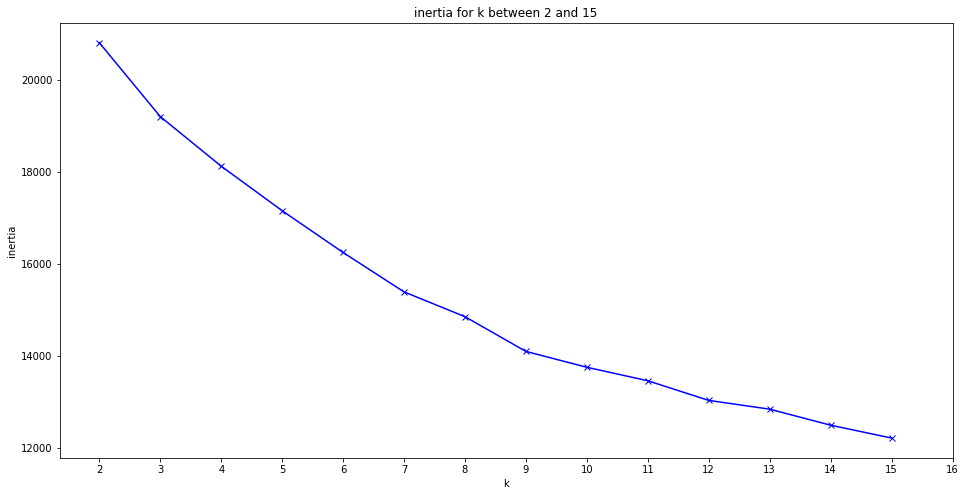

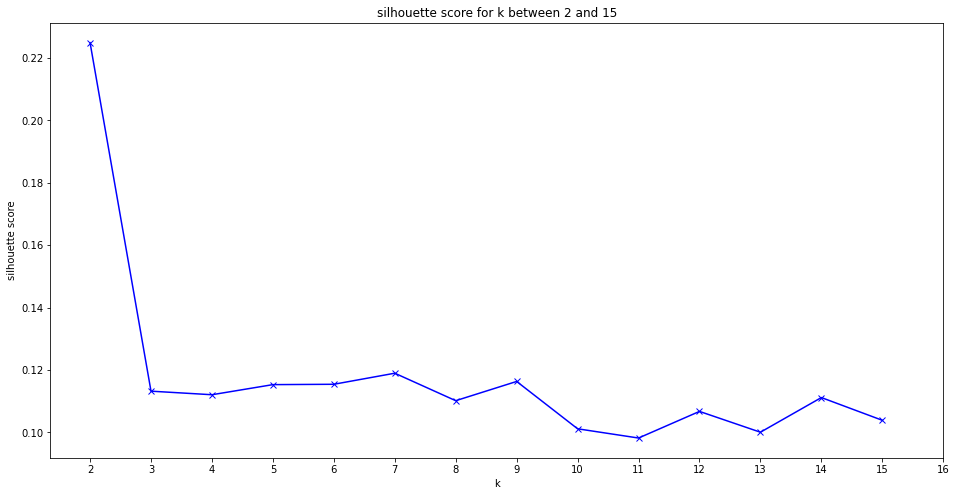

In [25]:
k_scores = kmeans_k_tuning(X_scaled, 2, 16)

### KMeans Clustering

In [26]:
# KMeans Clustering
kmeans = KMeans(n_clusters=9, random_state=88)
kmeans.fit(X_scaled)

# checking cluster size
clusters = kmeans.predict(X_scaled)
pd.Series(clusters).value_counts().sort_index()


0    388
1     81
2    197
3    197
4    165
5    377
6    118
7    260
8     86
dtype: int64

In [27]:
# adding cluster assignments to dataframe
hot100_clustered = hot100_audio_features.copy()
hot100_clustered["cluster"] = clusters

In [28]:
hot100_clustered.head()

,track_id,track_name,danceability,energy,key,loudness,mode,speechiness,acousticness,instrumentalness,liveness,valence,tempo,duration_ms,time_signature,cluster
0,5HCyWlXZPP0y6Gqq8TgA20,STAY (with Justin Bieber),0.591,0.764,1.0,-5.484,1.0,0.0483,0.0383,0.0,0.103,0.478,169.928,141806.0,4.0,7
1,4kux0P5UfguojB4h0lQnsj,STAY (with Justin Bieber),0.587,0.795,1.0,-5.557,1.0,0.0522,0.0370,0.0,0.103,0.476,169.951,141806.0,4.0,7
2,2WYs5LxOZfEyURXu7V0O1a,Stay With Me,0.684,0.844,9.0,-7.649,1.0,0.3350,0.3020,0.0,0.374,0.335,126.677,141505.0,5.0,3
3,5PjdY0CKGZdEuoNab3yDmX,STAY (with Justin Bieber),0.591,0.764,1.0,-5.484,1.0,0.0483,0.0383,0.0,0.103,0.478,169.928,141806.0,4.0,7
4,6uBhi9gBXWjanegOb2Phh0,Stay,0.690,0.622,5.0,-5.025,0.0,0.0622,0.2530,0.0,0.116,0.544,102.040,210091.0,4.0,5


# 4. Song recommendation

In [29]:
# finding song inside the same cluster after KMeans clustering returning 'similar' song 
# or predicting cluster if input song not yet in cluster df 
# inputs: df with songs, column with titles, column with clusters, outputs: df with similar song or new song 

def find_track_in_same_cluster(df, titles, clusters, transformer):
    # user input
    song_match = hot100_song_select()
    
    # case: song in input df
    if song_match in df[titles].values:
        for song in df[titles]:
            cluster_target = df[df[titles] == song_match][clusters].values[0]
            
        df_target_cluster = df[df[clusters] == cluster_target]
        df_target_cluster = df_target_cluster[df_target_cluster[titles] != song_match]
        df_target = df_target_cluster.sample(1)
        print('We picked a song you might also like.')
    
    # case: song not in input df   
    else:
        df_match = pd.DataFrame({'songs': [song_match]})
        df_match_ids = search_spotify_track_ids_list(df=df_match, tracks='songs')
        df_match_features = track_audio_features_to_df(df=df_match_ids, tracks='track_id').sample(1)
        df_target = predict_song_cluster(df=df_match_features, transformer=transformer, drop_col=['track_name', 'track_id'])
        df_target = pd.concat([df_match_features, df_target], axis=1)
        print('We are adding the song to our recommendation system so next time you ask for a sugesstion we have something for you.')
        
    return df_target


In [30]:
# assigns cluster to a song 

def predict_song_cluster(df, transformer, drop_col=[]):
    X_pred = df.copy()
    if drop_col != []:
        X_pred = X_pred.drop(drop_col, axis=1)
    # transform song data
    data_pred_scaled = transformer.transform(X_pred)
    X_pred_scaled = pd.DataFrame(data_pred_scaled)
    # cluster assignment
    clusters_pred = kmeans.predict(X_pred_scaled)
    X_pred["cluster"] = clusters_pred
    return X_pred

In [31]:
similar_song1 = find_track_in_same_cluster(df=hot100_clustered, titles='track_name', clusters='cluster', transformer=scaler)

What song do you like?  Bad Habits
Did you mean Bad Habits by Ed Sheeran?  yes


We picked a song you might also like.


In [32]:
similar_song1

,track_id,track_name,danceability,energy,key,loudness,mode,speechiness,acousticness,instrumentalness,liveness,valence,tempo,duration_ms,time_signature,cluster
329,18MzOzTLoYLRXTLWYomjgZ,MONTERO (Call Me By Your Name) - But Lil Nas X...,0.511,0.54,8.0,-6.402,0.0,0.174,0.191,0.0,0.377,0.711,119.248,170055.0,5.0,5


In [33]:
similar_song2 = find_track_in_same_cluster(df=hot100_clustered, titles='track_name', clusters='cluster', transformer=scaler)

What song do you like?  Digital Lion


Your song is not in the Hot 100.
We are adding the song to our recommendation system so next time you ask for a sugesstion we have something for you.


In [34]:
similar_song2

,track_id,track_name,danceability,energy,key,loudness,mode,speechiness,acousticness,instrumentalness,liveness,valence,tempo,duration_ms,time_signature,danceability,energy,key,loudness,mode,speechiness,acousticness,instrumentalness,liveness,valence,tempo,duration_ms,time_signature,cluster
1,65V6w29kGOfFI6QymLDwAj,Strangers - My Digital Enemy Remix,0.71,0.951,0,-4.102,0,0.046,0.011,0.524,0.022,0.893,123.979,319640,4,0.71,0.951,0,-4.102,0,0.046,0.011,0.524,0.022,0.893,123.979,319640,4,5


### Updating Cluster data

In [35]:
hot100_clustered = hot100_clustered.append(similar_song2, ignore_index=True)
hot100_clustered.tail()

# NOT WORKING - indexing

InvalidIndexError: Reindexing only valid with uniquely valued Index objects